In [1]:
# === IMPORTAÇÕES ===
import pandas as pd
import numpy as np
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# === 1. Carregar base ===
df = pd.read_excel("../Data/base_vendas_pdv_IA.xlsx", sheet_name="Sheet1")

# Ordena e cria colunas temporais
df = df.sort_values(["PDV_ID", "Data"])
df["Ano"] = df["Data"].dt.year
df["Mes"] = df["Data"].dt.month


In [3]:
# === 2. Features e Target ===
features = ["Vendas", "Custo", "Lucro", "Satisfacao", "Mes", "Ano"]
target = "Meta"

X = df[features]
y = df[target]
    # === 3. Tratar valores ausentes ===
# Preenche valores nulos com a mediana (mais robusto)
df[features + [target]] = df[features + [target]].fillna(df[features + [target]].median(numeric_only=True))

# Atualiza X e y após limpeza
X = df[features]
y = df[target]

# === 4. Divisão Treino/Teste ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# === 5. Função objetivo do Optuna ===
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 2.0),
        "random_state": 42,
        "tree_method": "hist",
        "n_jobs": -1
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

# === 6. Rodar o Optuna ===
study = optuna.create_study(direction="minimize")
print("🚀 Rodando Optuna para XGBoost (pode levar alguns minutos)...")
study.optimize(objective, n_trials=150, show_progress_bar=True)

# === 7. Resultado dos melhores parâmetros ===
best_params = study.best_params
print("\nMelhores parâmetros encontrados:")
for k, v in best_params.items():
    print(f"{k}: {v}")


[I 2025-11-09 13:37:35,171] A new study created in memory with name: no-name-8904467f-00e9-475a-b2e0-222c5ffc47da


🚀 Rodando Optuna para XGBoost (pode levar alguns minutos)...


Best trial: 0. Best value: 141.684:   1%|          | 1/150 [00:00<01:59,  1.25it/s]

[I 2025-11-09 13:37:35,971] Trial 0 finished with value: 141.68407441912956 and parameters: {'n_estimators': 952, 'learning_rate': 0.05689219133163196, 'max_depth': 5, 'subsample': 0.7020019042157126, 'colsample_bytree': 0.960095268917448, 'gamma': 1.9016337196793405, 'reg_alpha': 0.6750878414359334, 'reg_lambda': 0.011797307326162354}. Best is trial 0 with value: 141.68407441912956.


Best trial: 0. Best value: 141.684:   1%|▏         | 2/150 [00:01<01:23,  1.77it/s]

[I 2025-11-09 13:37:36,366] Trial 1 finished with value: 144.5134111483592 and parameters: {'n_estimators': 277, 'learning_rate': 0.05201646034846829, 'max_depth': 8, 'subsample': 0.782883513202183, 'colsample_bytree': 0.7880532153609165, 'gamma': 0.9057026420221553, 'reg_alpha': 0.6183112703344029, 'reg_lambda': 1.1790138544541873}. Best is trial 0 with value: 141.68407441912956.


Best trial: 2. Best value: 137.49:   2%|▏         | 3/150 [00:01<01:35,  1.54it/s] 

[I 2025-11-09 13:37:37,121] Trial 2 finished with value: 137.49037597464314 and parameters: {'n_estimators': 498, 'learning_rate': 0.017126574867890546, 'max_depth': 8, 'subsample': 0.5814296695228471, 'colsample_bytree': 0.9394641989092569, 'gamma': 1.1496940169962904, 'reg_alpha': 0.7343249134087588, 'reg_lambda': 0.12632812546190775}. Best is trial 2 with value: 137.49037597464314.


Best trial: 4. Best value: 134.386:   3%|▎         | 5/150 [00:02<01:04,  2.24it/s]

[I 2025-11-09 13:37:37,658] Trial 3 finished with value: 159.26556025762977 and parameters: {'n_estimators': 392, 'learning_rate': 0.15970927973605742, 'max_depth': 8, 'subsample': 0.8313792886133728, 'colsample_bytree': 0.7100205368207262, 'gamma': 4.761310971468589, 'reg_alpha': 0.7504489708901716, 'reg_lambda': 1.4938266652689818}. Best is trial 2 with value: 137.49037597464314.
[I 2025-11-09 13:37:37,825] Trial 4 finished with value: 134.38563660627642 and parameters: {'n_estimators': 269, 'learning_rate': 0.07554920534927835, 'max_depth': 4, 'subsample': 0.8370597832765564, 'colsample_bytree': 0.5794370990973507, 'gamma': 3.9372988134025055, 'reg_alpha': 0.05258851440862622, 'reg_lambda': 0.5302653894257501}. Best is trial 4 with value: 134.38563660627642.


Best trial: 4. Best value: 134.386:   4%|▍         | 6/150 [00:03<01:11,  2.01it/s]

[I 2025-11-09 13:37:38,420] Trial 5 finished with value: 143.97100487283194 and parameters: {'n_estimators': 861, 'learning_rate': 0.09696564885974396, 'max_depth': 5, 'subsample': 0.9575617469316787, 'colsample_bytree': 0.7727467010546747, 'gamma': 2.8398553272305067, 'reg_alpha': 1.1158524173725695, 'reg_lambda': 0.010462953542294207}. Best is trial 4 with value: 134.38563660627642.


Best trial: 6. Best value: 131.487:   5%|▍         | 7/150 [00:03<01:02,  2.27it/s]

[I 2025-11-09 13:37:38,741] Trial 6 finished with value: 131.48651980226145 and parameters: {'n_estimators': 660, 'learning_rate': 0.05653332728868629, 'max_depth': 3, 'subsample': 0.606452300609728, 'colsample_bytree': 0.8034860946297171, 'gamma': 2.5099271408795394, 'reg_alpha': 0.7136680999924898, 'reg_lambda': 1.3673784906819122}. Best is trial 6 with value: 131.48651980226145.


Best trial: 6. Best value: 131.487:   5%|▌         | 8/150 [00:04<01:01,  2.29it/s]

[I 2025-11-09 13:37:39,169] Trial 7 finished with value: 132.8160016483331 and parameters: {'n_estimators': 887, 'learning_rate': 0.06761266082037755, 'max_depth': 3, 'subsample': 0.6608266030877628, 'colsample_bytree': 0.9711812652687124, 'gamma': 2.8758083910611747, 'reg_alpha': 0.7864034736341894, 'reg_lambda': 0.8458960150642618}. Best is trial 6 with value: 131.48651980226145.


Best trial: 6. Best value: 131.487:   6%|▌         | 9/150 [00:04<01:20,  1.75it/s]

[I 2025-11-09 13:37:40,037] Trial 8 finished with value: 152.22946598940678 and parameters: {'n_estimators': 807, 'learning_rate': 0.16983015498352697, 'max_depth': 7, 'subsample': 0.9185314485497699, 'colsample_bytree': 0.9200394982023593, 'gamma': 2.7586690042478597, 'reg_alpha': 1.6011665405404953, 'reg_lambda': 1.6301236826715537}. Best is trial 6 with value: 131.48651980226145.


Best trial: 6. Best value: 131.487:   7%|▋         | 10/150 [00:05<01:34,  1.49it/s]

[I 2025-11-09 13:37:40,935] Trial 9 finished with value: 137.7814424123704 and parameters: {'n_estimators': 469, 'learning_rate': 0.016919652491277568, 'max_depth': 9, 'subsample': 0.8235806564075776, 'colsample_bytree': 0.9204485761173371, 'gamma': 4.82366346001943, 'reg_alpha': 0.08291320907596433, 'reg_lambda': 1.6275884664630702}. Best is trial 6 with value: 131.48651980226145.


Best trial: 6. Best value: 131.487:   7%|▋         | 11/150 [00:06<01:19,  1.75it/s]

[I 2025-11-09 13:37:41,272] Trial 10 finished with value: 144.55764236642128 and parameters: {'n_estimators': 696, 'learning_rate': 0.2991771270411391, 'max_depth': 3, 'subsample': 0.5132641149779376, 'colsample_bytree': 0.6501323153483214, 'gamma': 0.42695066172825813, 'reg_alpha': 1.9113890905210627, 'reg_lambda': 1.9571307182626367}. Best is trial 6 with value: 131.48651980226145.


Best trial: 11. Best value: 129.374:   8%|▊         | 12/150 [00:06<01:09,  1.99it/s]

[I 2025-11-09 13:37:41,616] Trial 11 finished with value: 129.37433909098309 and parameters: {'n_estimators': 669, 'learning_rate': 0.03071591484680182, 'max_depth': 3, 'subsample': 0.6784045523680188, 'colsample_bytree': 0.8530560552703096, 'gamma': 3.2645557649186547, 'reg_alpha': 1.174593585221412, 'reg_lambda': 0.7937124884436989}. Best is trial 11 with value: 129.37433909098309.


Best trial: 11. Best value: 129.374:   9%|▊         | 13/150 [00:06<01:08,  2.01it/s]

[I 2025-11-09 13:37:42,102] Trial 12 finished with value: 133.72478640382394 and parameters: {'n_estimators': 654, 'learning_rate': 0.0305374783947689, 'max_depth': 5, 'subsample': 0.6237550030491609, 'colsample_bytree': 0.8319397811649999, 'gamma': 3.6743064927208415, 'reg_alpha': 1.2480860754871141, 'reg_lambda': 0.9183807891660143}. Best is trial 11 with value: 129.37433909098309.


Best trial: 11. Best value: 129.374:   9%|▉         | 14/150 [00:07<01:03,  2.16it/s]

[I 2025-11-09 13:37:42,489] Trial 13 finished with value: 129.5987359052934 and parameters: {'n_estimators': 734, 'learning_rate': 0.03006555299165273, 'max_depth': 3, 'subsample': 0.5449986291693352, 'colsample_bytree': 0.88105191132825, 'gamma': 1.6830064654474302, 'reg_alpha': 1.3974185853504557, 'reg_lambda': 0.5678022714496374}. Best is trial 11 with value: 129.37433909098309.


Best trial: 11. Best value: 129.374:  10%|█         | 15/150 [00:08<01:12,  1.85it/s]

[I 2025-11-09 13:37:43,204] Trial 14 finished with value: 131.84959870728306 and parameters: {'n_estimators': 763, 'learning_rate': 0.010338766212546346, 'max_depth': 6, 'subsample': 0.5035440160758718, 'colsample_bytree': 0.8574394507865546, 'gamma': 1.7632561455896347, 'reg_alpha': 1.4241371560701184, 'reg_lambda': 0.5268844534850183}. Best is trial 11 with value: 129.37433909098309.


Best trial: 11. Best value: 129.374:  11%|█         | 16/150 [00:08<01:04,  2.06it/s]

[I 2025-11-09 13:37:43,563] Trial 15 finished with value: 129.96750994220469 and parameters: {'n_estimators': 553, 'learning_rate': 0.0294880800726316, 'max_depth': 4, 'subsample': 0.7236934393996981, 'colsample_bytree': 0.8654052918445614, 'gamma': 3.600857870638749, 'reg_alpha': 1.6430212162467526, 'reg_lambda': 0.602311161966434}. Best is trial 11 with value: 129.37433909098309.


Best trial: 11. Best value: 129.374:  11%|█▏        | 17/150 [00:10<01:59,  1.12it/s]

[I 2025-11-09 13:37:45,418] Trial 16 finished with value: 151.91995760551788 and parameters: {'n_estimators': 749, 'learning_rate': 0.02688052258819198, 'max_depth': 10, 'subsample': 0.6543723612257057, 'colsample_bytree': 0.7208332578529406, 'gamma': 1.9136629976630866, 'reg_alpha': 1.9502582612162633, 'reg_lambda': 0.3371569628707959}. Best is trial 11 with value: 129.37433909098309.


Best trial: 11. Best value: 129.374:  12%|█▏        | 18/150 [00:10<01:37,  1.36it/s]

[I 2025-11-09 13:37:45,786] Trial 17 finished with value: 130.89654042753781 and parameters: {'n_estimators': 570, 'learning_rate': 0.03845529537736377, 'max_depth': 4, 'subsample': 0.5734587201777787, 'colsample_bytree': 0.879696735704873, 'gamma': 1.3593969361152696, 'reg_alpha': 1.027536843018441, 'reg_lambda': 0.7504717289330228}. Best is trial 11 with value: 129.37433909098309.


Best trial: 11. Best value: 129.374:  13%|█▎        | 19/150 [00:10<01:22,  1.59it/s]

[I 2025-11-09 13:37:46,164] Trial 18 finished with value: 132.1845731224204 and parameters: {'n_estimators': 396, 'learning_rate': 0.018726124614335548, 'max_depth': 6, 'subsample': 0.5630157369442014, 'colsample_bytree': 0.6870413887277911, 'gamma': 0.060203140439393454, 'reg_alpha': 1.309337493163351, 'reg_lambda': 1.125224860105882}. Best is trial 11 with value: 129.37433909098309.


Best trial: 11. Best value: 129.374:  13%|█▎        | 20/150 [00:11<01:10,  1.83it/s]

[I 2025-11-09 13:37:46,511] Trial 19 finished with value: 142.49904648498918 and parameters: {'n_estimators': 658, 'learning_rate': 0.010171787470550572, 'max_depth': 3, 'subsample': 0.6887534110214977, 'colsample_bytree': 0.5040922075335921, 'gamma': 3.2815344490488663, 'reg_alpha': 0.3719947630856997, 'reg_lambda': 0.2829553090485295}. Best is trial 11 with value: 129.37433909098309.


Best trial: 11. Best value: 129.374:  14%|█▍        | 21/150 [00:11<01:11,  1.80it/s]

[I 2025-11-09 13:37:47,097] Trial 20 finished with value: 133.13040048851155 and parameters: {'n_estimators': 971, 'learning_rate': 0.040901164284186414, 'max_depth': 4, 'subsample': 0.7603852735353963, 'colsample_bytree': 0.9958017645195838, 'gamma': 4.326982822650285, 'reg_alpha': 1.5758029360279733, 'reg_lambda': 0.7118733996876919}. Best is trial 11 with value: 129.37433909098309.


Best trial: 11. Best value: 129.374:  15%|█▍        | 22/150 [00:12<01:03,  2.01it/s]

[I 2025-11-09 13:37:47,457] Trial 21 finished with value: 129.4350009347208 and parameters: {'n_estimators': 560, 'learning_rate': 0.022102723756598455, 'max_depth': 4, 'subsample': 0.7020173402590547, 'colsample_bytree': 0.8780311772381391, 'gamma': 3.39660936527553, 'reg_alpha': 1.6910862409661964, 'reg_lambda': 0.5797003961932572}. Best is trial 11 with value: 129.37433909098309.


Best trial: 11. Best value: 129.374:  15%|█▌        | 23/150 [00:12<00:56,  2.25it/s]

[I 2025-11-09 13:37:47,776] Trial 22 finished with value: 129.5412533051113 and parameters: {'n_estimators': 580, 'learning_rate': 0.020308269295203133, 'max_depth': 3, 'subsample': 0.6423643713380737, 'colsample_bytree': 0.8900687027738649, 'gamma': 3.2179075688709347, 'reg_alpha': 1.799217083904725, 'reg_lambda': 0.3845270452872787}. Best is trial 11 with value: 129.37433909098309.


Best trial: 23. Best value: 129.093:  16%|█▌        | 24/150 [00:12<00:53,  2.35it/s]

[I 2025-11-09 13:37:48,159] Trial 23 finished with value: 129.09340209001266 and parameters: {'n_estimators': 603, 'learning_rate': 0.021848156707261868, 'max_depth': 4, 'subsample': 0.6588781205973193, 'colsample_bytree': 0.8339770012258007, 'gamma': 3.2306217089801517, 'reg_alpha': 1.76339107364026, 'reg_lambda': 0.32864331507547184}. Best is trial 23 with value: 129.09340209001266.


Best trial: 23. Best value: 129.093:  17%|█▋        | 25/150 [00:13<00:51,  2.45it/s]

[I 2025-11-09 13:37:48,526] Trial 24 finished with value: 130.94490611334268 and parameters: {'n_estimators': 469, 'learning_rate': 0.014008642346931981, 'max_depth': 5, 'subsample': 0.7268429257465382, 'colsample_bytree': 0.8268583220807888, 'gamma': 4.136099305540625, 'reg_alpha': 1.7799138248441109, 'reg_lambda': 1.0275101143822338}. Best is trial 23 with value: 129.09340209001266.


Best trial: 23. Best value: 129.093:  17%|█▋        | 26/150 [00:13<00:49,  2.49it/s]

[I 2025-11-09 13:37:48,912] Trial 25 finished with value: 129.64330009028598 and parameters: {'n_estimators': 614, 'learning_rate': 0.024136574844579456, 'max_depth': 4, 'subsample': 0.7754918639070069, 'colsample_bytree': 0.7658004547472933, 'gamma': 3.2991012709748264, 'reg_alpha': 1.4916076207619835, 'reg_lambda': 0.2149981812675954}. Best is trial 23 with value: 129.09340209001266.


Best trial: 23. Best value: 129.093:  18%|█▊        | 27/150 [00:14<00:44,  2.77it/s]

[I 2025-11-09 13:37:49,180] Trial 26 finished with value: 132.5065517958155 and parameters: {'n_estimators': 397, 'learning_rate': 0.013434919936745041, 'max_depth': 4, 'subsample': 0.6815334409116508, 'colsample_bytree': 0.8198105399170559, 'gamma': 2.2351576995650535, 'reg_alpha': 1.1729468332257391, 'reg_lambda': 0.4278703764626543}. Best is trial 23 with value: 129.09340209001266.


Best trial: 23. Best value: 129.093:  19%|█▊        | 28/150 [00:14<00:47,  2.55it/s]

[I 2025-11-09 13:37:49,641] Trial 27 finished with value: 136.85785579849338 and parameters: {'n_estimators': 506, 'learning_rate': 0.04025127989796581, 'max_depth': 6, 'subsample': 0.6080037596209587, 'colsample_bytree': 0.7430236497569335, 'gamma': 2.3707546804608786, 'reg_alpha': 1.8091104788555497, 'reg_lambda': 0.7072536197750068}. Best is trial 23 with value: 129.09340209001266.


Best trial: 23. Best value: 129.093:  19%|█▉        | 29/150 [00:14<00:50,  2.41it/s]

[I 2025-11-09 13:37:50,112] Trial 28 finished with value: 131.10576660732056 and parameters: {'n_estimators': 616, 'learning_rate': 0.022883971929154378, 'max_depth': 5, 'subsample': 0.727953022995848, 'colsample_bytree': 0.9046611017552272, 'gamma': 3.716005488518067, 'reg_alpha': 0.9492759920004237, 'reg_lambda': 0.8994816263656507}. Best is trial 23 with value: 129.09340209001266.


Best trial: 23. Best value: 129.093:  20%|██        | 30/150 [00:15<00:56,  2.11it/s]

[I 2025-11-09 13:37:50,718] Trial 29 finished with value: 131.2013443856869 and parameters: {'n_estimators': 797, 'learning_rate': 0.014592024445771849, 'max_depth': 5, 'subsample': 0.7000502406311103, 'colsample_bytree': 0.9606604625678705, 'gamma': 4.429108132745091, 'reg_alpha': 1.994375171502581, 'reg_lambda': 0.2407739665357629}. Best is trial 23 with value: 129.09340209001266.


Best trial: 23. Best value: 129.093:  21%|██        | 31/150 [00:15<00:51,  2.31it/s]

[I 2025-11-09 13:37:51,057] Trial 30 finished with value: 130.34845105249175 and parameters: {'n_estimators': 531, 'learning_rate': 0.035259674918701626, 'max_depth': 4, 'subsample': 0.8771139293019355, 'colsample_bytree': 0.8479488138715185, 'gamma': 3.1217986879160313, 'reg_alpha': 1.7037105131172543, 'reg_lambda': 0.09546304690185281}. Best is trial 23 with value: 129.09340209001266.


Best trial: 23. Best value: 129.093:  21%|██▏       | 32/150 [00:16<00:48,  2.45it/s]

[I 2025-11-09 13:37:51,410] Trial 31 finished with value: 129.50943507356462 and parameters: {'n_estimators': 571, 'learning_rate': 0.020994749598585407, 'max_depth': 3, 'subsample': 0.6477726680758471, 'colsample_bytree': 0.9020219249140434, 'gamma': 3.4259585659909435, 'reg_alpha': 1.8140373566261412, 'reg_lambda': 0.37184566887352555}. Best is trial 23 with value: 129.09340209001266.


Best trial: 23. Best value: 129.093:  22%|██▏       | 33/150 [00:16<00:46,  2.52it/s]

[I 2025-11-09 13:37:51,781] Trial 32 finished with value: 129.43357912459462 and parameters: {'n_estimators': 698, 'learning_rate': 0.021303677390569927, 'max_depth': 3, 'subsample': 0.655940359283351, 'colsample_bytree': 0.9356596936688161, 'gamma': 3.442064341474811, 'reg_alpha': 1.5475529691462984, 'reg_lambda': 0.4350319382123401}. Best is trial 23 with value: 129.09340209001266.


Best trial: 23. Best value: 129.093:  23%|██▎       | 34/150 [00:16<00:44,  2.58it/s]

[I 2025-11-09 13:37:52,143] Trial 33 finished with value: 130.5908083952898 and parameters: {'n_estimators': 693, 'learning_rate': 0.04939380874135384, 'max_depth': 3, 'subsample': 0.6756991364677393, 'colsample_bytree': 0.9394098487939323, 'gamma': 3.892928901075435, 'reg_alpha': 1.47268762434038, 'reg_lambda': 0.47735792631132895}. Best is trial 23 with value: 129.09340209001266.


Best trial: 23. Best value: 129.093:  23%|██▎       | 35/150 [00:17<00:38,  2.96it/s]

[I 2025-11-09 13:37:52,369] Trial 34 finished with value: 130.41393151241277 and parameters: {'n_estimators': 326, 'learning_rate': 0.025182872899632273, 'max_depth': 4, 'subsample': 0.7298010742917972, 'colsample_bytree': 0.7965443850388844, 'gamma': 3.0159591998564674, 'reg_alpha': 1.3054107791714546, 'reg_lambda': 0.6755769370838557}. Best is trial 23 with value: 129.09340209001266.


Best trial: 35. Best value: 128.951:  24%|██▍       | 36/150 [00:17<00:37,  3.07it/s]

[I 2025-11-09 13:37:52,667] Trial 35 finished with value: 128.9514134341066 and parameters: {'n_estimators': 442, 'learning_rate': 0.015896450827833697, 'max_depth': 4, 'subsample': 0.7881496505260163, 'colsample_bytree': 0.9931326334283928, 'gamma': 2.689471594392621, 'reg_alpha': 0.9156415501081645, 'reg_lambda': 0.12559695568356755}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  25%|██▍       | 37/150 [00:17<00:38,  2.96it/s]

[I 2025-11-09 13:37:53,031] Trial 36 finished with value: 130.21500447975015 and parameters: {'n_estimators': 446, 'learning_rate': 0.0122444204153165, 'max_depth': 5, 'subsample': 0.7771855941277546, 'colsample_bytree': 0.9956216057869468, 'gamma': 2.6417749326060473, 'reg_alpha': 0.8892260921010817, 'reg_lambda': 0.1422278685605715}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  25%|██▌       | 38/150 [00:18<00:36,  3.06it/s]

[I 2025-11-09 13:37:53,331] Trial 37 finished with value: 134.75015597745306 and parameters: {'n_estimators': 222, 'learning_rate': 0.016609589685565813, 'max_depth': 7, 'subsample': 0.8067490166648654, 'colsample_bytree': 0.945345796758075, 'gamma': 2.1397685649253373, 'reg_alpha': 0.4350100112349814, 'reg_lambda': 0.1397788633722061}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  26%|██▌       | 39/150 [00:18<00:40,  2.77it/s]

[I 2025-11-09 13:37:53,773] Trial 38 finished with value: 131.17284183910058 and parameters: {'n_estimators': 873, 'learning_rate': 0.048057108440738905, 'max_depth': 3, 'subsample': 0.8631175345749807, 'colsample_bytree': 0.9706393603526345, 'gamma': 2.5961808950050074, 'reg_alpha': 0.6243003315605987, 'reg_lambda': 0.09425393653502442}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  27%|██▋       | 40/150 [00:19<00:43,  2.53it/s]

[I 2025-11-09 13:37:54,248] Trial 39 finished with value: 129.75102700095505 and parameters: {'n_estimators': 918, 'learning_rate': 0.033737522789582204, 'max_depth': 3, 'subsample': 0.6029854811496758, 'colsample_bytree': 0.9321702662506373, 'gamma': 4.55500980230089, 'reg_alpha': 1.0647859830220432, 'reg_lambda': 1.1897158039567381}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  27%|██▋       | 41/150 [00:19<00:46,  2.34it/s]

[I 2025-11-09 13:37:54,750] Trial 40 finished with value: 137.91385866369092 and parameters: {'n_estimators': 822, 'learning_rate': 0.07339023554015507, 'max_depth': 4, 'subsample': 0.8012269502988619, 'colsample_bytree': 0.9771145386248932, 'gamma': 4.071055598483329, 'reg_alpha': 0.8236340196267384, 'reg_lambda': 0.03800370248954499}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  28%|██▊       | 42/150 [00:19<00:45,  2.39it/s]

[I 2025-11-09 13:37:55,146] Trial 41 finished with value: 129.12568781438864 and parameters: {'n_estimators': 617, 'learning_rate': 0.016797870879331232, 'max_depth': 4, 'subsample': 0.7526470262959672, 'colsample_bytree': 0.9098944952671011, 'gamma': 2.9470285620364938, 'reg_alpha': 1.1715068289027553, 'reg_lambda': 0.7924517035929804}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  29%|██▊       | 43/150 [00:20<00:46,  2.29it/s]

[I 2025-11-09 13:37:55,631] Trial 42 finished with value: 130.12661116498072 and parameters: {'n_estimators': 627, 'learning_rate': 0.016231398258671995, 'max_depth': 5, 'subsample': 0.7574139182775164, 'colsample_bytree': 0.9176556436220249, 'gamma': 2.8640080128267713, 'reg_alpha': 1.1530268092334923, 'reg_lambda': 0.7984698827502041}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  29%|██▉       | 44/150 [00:20<00:44,  2.38it/s]

[I 2025-11-09 13:37:56,010] Trial 43 finished with value: 129.53201095485088 and parameters: {'n_estimators': 704, 'learning_rate': 0.011909145780123252, 'max_depth': 3, 'subsample': 0.6331902962519119, 'colsample_bytree': 0.9462232978993262, 'gamma': 3.041933417077224, 'reg_alpha': 0.908242570356675, 'reg_lambda': 1.0042028854052079}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  30%|███       | 45/150 [00:21<00:38,  2.76it/s]

[I 2025-11-09 13:37:56,238] Trial 44 finished with value: 129.303228594702 and parameters: {'n_estimators': 323, 'learning_rate': 0.018319775078362563, 'max_depth': 4, 'subsample': 0.9781448784118296, 'colsample_bytree': 0.8481955244820528, 'gamma': 3.5794570229705185, 'reg_alpha': 1.5437226549357488, 'reg_lambda': 1.3012664532326186}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  31%|███       | 46/150 [00:21<00:36,  2.82it/s]

[I 2025-11-09 13:37:56,573] Trial 45 finished with value: 133.6178167321547 and parameters: {'n_estimators': 335, 'learning_rate': 0.018406702140151644, 'max_depth': 6, 'subsample': 0.9786004987134089, 'colsample_bytree': 0.7802683308267384, 'gamma': 3.8223860384344985, 'reg_alpha': 1.208384039054441, 'reg_lambda': 1.384781855353603}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  31%|███▏      | 47/150 [00:21<00:32,  3.15it/s]

[I 2025-11-09 13:37:56,804] Trial 46 finished with value: 130.15618149667418 and parameters: {'n_estimators': 324, 'learning_rate': 0.0152011140833142, 'max_depth': 4, 'subsample': 0.9345640525487623, 'colsample_bytree': 0.8446924045396138, 'gamma': 2.8006905541909166, 'reg_alpha': 1.3356208067586797, 'reg_lambda': 1.318183431990446}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  32%|███▏      | 48/150 [00:21<00:29,  3.49it/s]

[I 2025-11-09 13:37:57,019] Trial 47 finished with value: 135.59512600496882 and parameters: {'n_estimators': 278, 'learning_rate': 0.12227527490151592, 'max_depth': 5, 'subsample': 0.9997824723157277, 'colsample_bytree': 0.7987173339147371, 'gamma': 2.4645363525638317, 'reg_alpha': 0.490640275609695, 'reg_lambda': 1.6480437321590542}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  33%|███▎      | 49/150 [00:22<00:29,  3.46it/s]

[I 2025-11-09 13:37:57,314] Trial 48 finished with value: 129.54862442880307 and parameters: {'n_estimators': 448, 'learning_rate': 0.02753514025199372, 'max_depth': 4, 'subsample': 0.8951479808846003, 'colsample_bytree': 0.8228765615393653, 'gamma': 3.5669547304357936, 'reg_alpha': 1.0970800626814643, 'reg_lambda': 1.136831199981286}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  33%|███▎      | 50/150 [00:22<00:44,  2.27it/s]

[I 2025-11-09 13:37:58,109] Trial 49 finished with value: 136.26789459996255 and parameters: {'n_estimators': 522, 'learning_rate': 0.018024956435109075, 'max_depth': 8, 'subsample': 0.8483672063882283, 'colsample_bytree': 0.865199682199244, 'gamma': 2.0314654025162078, 'reg_alpha': 0.7906177746088083, 'reg_lambda': 1.2420473120466768}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  34%|███▍      | 51/150 [00:23<00:52,  1.89it/s]

[I 2025-11-09 13:37:58,845] Trial 50 finished with value: 144.1321850010134 and parameters: {'n_estimators': 365, 'learning_rate': 0.011836164350799537, 'max_depth': 9, 'subsample': 0.8249603313574082, 'colsample_bytree': 0.749770541850705, 'gamma': 1.519328604760108, 'reg_alpha': 1.0069674143314247, 'reg_lambda': 1.4945782491410884}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  35%|███▍      | 52/150 [00:24<00:47,  2.08it/s]

[I 2025-11-09 13:37:59,212] Trial 51 finished with value: 129.3142980246874 and parameters: {'n_estimators': 685, 'learning_rate': 0.020855368814083872, 'max_depth': 3, 'subsample': 0.669812879308574, 'colsample_bytree': 0.8963861939347264, 'gamma': 3.4995015862609335, 'reg_alpha': 1.5266225061483334, 'reg_lambda': 0.4670126870989788}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  35%|███▌      | 53/150 [00:24<00:42,  2.26it/s]

[I 2025-11-09 13:37:59,565] Trial 52 finished with value: 129.22242614554156 and parameters: {'n_estimators': 657, 'learning_rate': 0.025254279574580905, 'max_depth': 3, 'subsample': 0.7430197500423656, 'colsample_bytree': 0.8956811578840334, 'gamma': 3.008438735830137, 'reg_alpha': 1.3839148653166238, 'reg_lambda': 0.9214287996824746}. Best is trial 35 with value: 128.9514134341066.


Best trial: 35. Best value: 128.951:  36%|███▌      | 54/150 [00:24<00:41,  2.31it/s]

[I 2025-11-09 13:37:59,976] Trial 53 finished with value: 129.07810061664702 and parameters: {'n_estimators': 636, 'learning_rate': 0.018437683115783383, 'max_depth': 4, 'subsample': 0.7443637754605922, 'colsample_bytree': 0.9039506694415583, 'gamma': 2.984320745704019, 'reg_alpha': 1.3617492595608947, 'reg_lambda': 0.8812928915025009}. Best is trial 35 with value: 128.9514134341066.


Best trial: 54. Best value: 128.748:  37%|███▋      | 55/150 [00:25<00:40,  2.34it/s]

[I 2025-11-09 13:38:00,390] Trial 54 finished with value: 128.74827486626006 and parameters: {'n_estimators': 637, 'learning_rate': 0.013497003171349841, 'max_depth': 4, 'subsample': 0.7085044898589219, 'colsample_bytree': 0.9202918036784364, 'gamma': 2.949081275131177, 'reg_alpha': 1.395036342147797, 'reg_lambda': 0.8868931613417285}. Best is trial 54 with value: 128.74827486626006.


Best trial: 54. Best value: 128.748:  37%|███▋      | 56/150 [00:25<00:42,  2.21it/s]

[I 2025-11-09 13:38:00,901] Trial 55 finished with value: 129.83357392892896 and parameters: {'n_estimators': 642, 'learning_rate': 0.012894995088291792, 'max_depth': 5, 'subsample': 0.7410229241529406, 'colsample_bytree': 0.91381491189675, 'gamma': 2.9571797676852984, 'reg_alpha': 1.3964282883721735, 'reg_lambda': 0.9141163301107798}. Best is trial 54 with value: 128.74827486626006.


Best trial: 54. Best value: 128.748:  38%|███▊      | 57/150 [00:26<00:40,  2.30it/s]

[I 2025-11-09 13:38:01,293] Trial 56 finished with value: 128.9526960495283 and parameters: {'n_estimators': 595, 'learning_rate': 0.010132188681199932, 'max_depth': 4, 'subsample': 0.7068364329301682, 'colsample_bytree': 0.9817874205627884, 'gamma': 2.7016169301924533, 'reg_alpha': 1.297757408053734, 'reg_lambda': 1.078632328013687}. Best is trial 54 with value: 128.74827486626006.


Best trial: 54. Best value: 128.748:  39%|███▊      | 58/150 [00:26<00:41,  2.23it/s]

[I 2025-11-09 13:38:01,774] Trial 57 finished with value: 129.64549496824634 and parameters: {'n_estimators': 596, 'learning_rate': 0.010081764143099874, 'max_depth': 5, 'subsample': 0.7865967811728926, 'colsample_bytree': 0.9875651456752538, 'gamma': 2.683995544451037, 'reg_alpha': 1.2395982229287508, 'reg_lambda': 1.090282531970394}. Best is trial 54 with value: 128.74827486626006.


Best trial: 54. Best value: 128.748:  39%|███▉      | 59/150 [00:26<00:38,  2.37it/s]

[I 2025-11-09 13:38:02,136] Trial 58 finished with value: 129.0679132502334 and parameters: {'n_estimators': 542, 'learning_rate': 0.011710048948105352, 'max_depth': 4, 'subsample': 0.6990509646441727, 'colsample_bytree': 0.9574270771560343, 'gamma': 2.2712335627792264, 'reg_alpha': 1.2761372020812596, 'reg_lambda': 1.0515993290524992}. Best is trial 54 with value: 128.74827486626006.


Best trial: 54. Best value: 128.748:  40%|████      | 60/150 [00:27<00:42,  2.12it/s]

[I 2025-11-09 13:38:02,723] Trial 59 finished with value: 132.29942252105138 and parameters: {'n_estimators': 474, 'learning_rate': 0.011308035667773806, 'max_depth': 7, 'subsample': 0.6966042504063833, 'colsample_bytree': 0.9545450071545766, 'gamma': 2.511400048342528, 'reg_alpha': 1.63952301444544, 'reg_lambda': 1.016616633695919}. Best is trial 54 with value: 128.74827486626006.


Best trial: 60. Best value: 128.707:  41%|████      | 61/150 [00:27<00:38,  2.28it/s]

[I 2025-11-09 13:38:03,081] Trial 60 finished with value: 128.70697057759986 and parameters: {'n_estimators': 542, 'learning_rate': 0.014501635162994225, 'max_depth': 4, 'subsample': 0.7138105341143242, 'colsample_bytree': 0.9726389516061315, 'gamma': 2.282389118041314, 'reg_alpha': 1.2831470983076367, 'reg_lambda': 1.8883097105530604}. Best is trial 60 with value: 128.70697057759986.


Best trial: 61. Best value: 128.678:  41%|████▏     | 62/150 [00:28<00:36,  2.43it/s]

[I 2025-11-09 13:38:03,433] Trial 61 finished with value: 128.67786148167255 and parameters: {'n_estimators': 540, 'learning_rate': 0.014543189223760983, 'max_depth': 4, 'subsample': 0.711714702970159, 'colsample_bytree': 0.9743187622425633, 'gamma': 2.3241859362313795, 'reg_alpha': 1.2914353297433812, 'reg_lambda': 1.892059921470103}. Best is trial 61 with value: 128.67786148167255.


Best trial: 61. Best value: 128.678:  42%|████▏     | 63/150 [00:28<00:34,  2.53it/s]

[I 2025-11-09 13:38:03,790] Trial 62 finished with value: 128.85235211258416 and parameters: {'n_estimators': 531, 'learning_rate': 0.014745632538576801, 'max_depth': 4, 'subsample': 0.7153070103697575, 'colsample_bytree': 0.975922038953285, 'gamma': 2.3073297958259653, 'reg_alpha': 1.291279301879049, 'reg_lambda': 1.662160479612558}. Best is trial 61 with value: 128.67786148167255.


Best trial: 63. Best value: 128.669:  43%|████▎     | 64/150 [00:28<00:33,  2.58it/s]

[I 2025-11-09 13:38:04,156] Trial 63 finished with value: 128.66903427028058 and parameters: {'n_estimators': 548, 'learning_rate': 0.014260944400488588, 'max_depth': 4, 'subsample': 0.7090971874482225, 'colsample_bytree': 0.9750923419039732, 'gamma': 1.8430104641820995, 'reg_alpha': 1.2655648749098785, 'reg_lambda': 1.9734100887174209}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  43%|████▎     | 65/150 [00:29<00:33,  2.55it/s]

[I 2025-11-09 13:38:04,559] Trial 64 finished with value: 129.66438669648562 and parameters: {'n_estimators': 504, 'learning_rate': 0.013282888333923668, 'max_depth': 5, 'subsample': 0.710522786344433, 'colsample_bytree': 0.9773779560374203, 'gamma': 1.156302186113062, 'reg_alpha': 1.1073451326729584, 'reg_lambda': 1.9543046922078637}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  44%|████▍     | 66/150 [00:29<00:30,  2.77it/s]

[I 2025-11-09 13:38:04,849] Trial 65 finished with value: 129.09006672793214 and parameters: {'n_estimators': 421, 'learning_rate': 0.014625821793069135, 'max_depth': 4, 'subsample': 0.7162319049269129, 'colsample_bytree': 0.9948015873032987, 'gamma': 1.9021651888205735, 'reg_alpha': 1.4370763183741315, 'reg_lambda': 1.866176038584392}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  45%|████▍     | 67/150 [00:30<00:30,  2.71it/s]

[I 2025-11-09 13:38:05,238] Trial 66 finished with value: 129.82626268302872 and parameters: {'n_estimators': 476, 'learning_rate': 0.010847906232273495, 'max_depth': 5, 'subsample': 0.7620809308487003, 'colsample_bytree': 0.9645970487939011, 'gamma': 1.672875897384955, 'reg_alpha': 1.2427437929034604, 'reg_lambda': 1.782460744459338}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  45%|████▌     | 68/150 [00:30<00:30,  2.68it/s]

[I 2025-11-09 13:38:05,617] Trial 67 finished with value: 128.76247232880982 and parameters: {'n_estimators': 583, 'learning_rate': 0.015306393266949705, 'max_depth': 4, 'subsample': 0.6855660871186166, 'colsample_bytree': 0.980045960359739, 'gamma': 2.1411507931353237, 'reg_alpha': 1.456241115783167, 'reg_lambda': 1.8309310365358413}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  46%|████▌     | 69/150 [00:30<00:29,  2.76it/s]

[I 2025-11-09 13:38:05,959] Trial 68 finished with value: 150.17301535744338 and parameters: {'n_estimators': 524, 'learning_rate': 0.27771231500157845, 'max_depth': 4, 'subsample': 0.6860798501281529, 'colsample_bytree': 0.9291090917349559, 'gamma': 2.1133351448877638, 'reg_alpha': 1.4721551696468276, 'reg_lambda': 1.7614546696661064}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  47%|████▋     | 70/150 [00:31<00:30,  2.59it/s]

[I 2025-11-09 13:38:06,395] Trial 69 finished with value: 129.66242917810598 and parameters: {'n_estimators': 554, 'learning_rate': 0.015128110746891398, 'max_depth': 5, 'subsample': 0.7991644193540849, 'colsample_bytree': 0.9965417791856185, 'gamma': 2.352947640589614, 'reg_alpha': 0.9786272736190764, 'reg_lambda': 1.9918761401011273}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  47%|████▋     | 71/150 [00:31<00:28,  2.73it/s]

[I 2025-11-09 13:38:06,716] Trial 70 finished with value: 134.11054446814194 and parameters: {'n_estimators': 488, 'learning_rate': 0.015814926951105954, 'max_depth': 4, 'subsample': 0.6718381532139914, 'colsample_bytree': 0.5945385322223856, 'gamma': 1.785068229822303, 'reg_alpha': 1.61770848824425, 'reg_lambda': 1.8707819050536876}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  48%|████▊     | 72/150 [00:31<00:28,  2.69it/s]

[I 2025-11-09 13:38:07,102] Trial 71 finished with value: 128.76319511173656 and parameters: {'n_estimators': 584, 'learning_rate': 0.01342064010021178, 'max_depth': 4, 'subsample': 0.7145347119374915, 'colsample_bytree': 0.9796218843216683, 'gamma': 1.9960506039559998, 'reg_alpha': 1.337297410889299, 'reg_lambda': 1.7717698466527658}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  49%|████▊     | 73/150 [00:32<00:28,  2.69it/s]

[I 2025-11-09 13:38:07,474] Trial 72 finished with value: 128.75650967388032 and parameters: {'n_estimators': 563, 'learning_rate': 0.013431836387082301, 'max_depth': 4, 'subsample': 0.7261949107350248, 'colsample_bytree': 0.971839380498372, 'gamma': 2.0118911204697967, 'reg_alpha': 1.4245154912106455, 'reg_lambda': 1.733012613597698}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  49%|████▉     | 74/150 [00:32<00:28,  2.65it/s]

[I 2025-11-09 13:38:07,861] Trial 73 finished with value: 128.92497283551677 and parameters: {'n_estimators': 579, 'learning_rate': 0.013400446106425653, 'max_depth': 4, 'subsample': 0.7315560600174621, 'colsample_bytree': 0.9673453325180663, 'gamma': 1.3321258963963645, 'reg_alpha': 1.3476326378164405, 'reg_lambda': 1.7118501429449315}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  50%|█████     | 75/150 [00:32<00:26,  2.82it/s]

[I 2025-11-09 13:38:08,165] Trial 74 finished with value: 129.86049584922552 and parameters: {'n_estimators': 544, 'learning_rate': 0.013873644821069118, 'max_depth': 3, 'subsample': 0.7117929389751958, 'colsample_bytree': 0.9497022966813656, 'gamma': 2.0746834538085897, 'reg_alpha': 1.4346242487673775, 'reg_lambda': 1.8682812159179951}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  51%|█████     | 76/150 [00:33<00:27,  2.73it/s]

[I 2025-11-09 13:38:08,556] Trial 75 finished with value: 128.8292819386608 and parameters: {'n_estimators': 590, 'learning_rate': 0.012449556620311443, 'max_depth': 4, 'subsample': 0.6888813848729698, 'colsample_bytree': 0.9774523761003155, 'gamma': 0.8307128747699641, 'reg_alpha': 1.4996190615464244, 'reg_lambda': 1.5832123247158107}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  51%|█████▏    | 77/150 [00:33<00:28,  2.52it/s]

[I 2025-11-09 13:38:09,023] Trial 76 finished with value: 129.73185366072744 and parameters: {'n_estimators': 588, 'learning_rate': 0.012709462115826582, 'max_depth': 5, 'subsample': 0.686035262651907, 'colsample_bytree': 0.927621299696911, 'gamma': 0.7305780268923554, 'reg_alpha': 1.49710166721752, 'reg_lambda': 1.5493278478004446}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  52%|█████▏    | 78/150 [00:34<00:28,  2.53it/s]

[I 2025-11-09 13:38:09,413] Trial 77 finished with value: 129.63980142461426 and parameters: {'n_estimators': 722, 'learning_rate': 0.011042199750336311, 'max_depth': 3, 'subsample': 0.6299745022049307, 'colsample_bytree': 0.9562111055405129, 'gamma': 0.7530147017918092, 'reg_alpha': 1.7066784564574662, 'reg_lambda': 1.816761041739457}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  53%|█████▎    | 79/150 [00:34<00:27,  2.57it/s]

[I 2025-11-09 13:38:09,792] Trial 78 finished with value: 128.95214099236253 and parameters: {'n_estimators': 569, 'learning_rate': 0.01979495079018033, 'max_depth': 4, 'subsample': 0.6637251262599, 'colsample_bytree': 0.9826939206453744, 'gamma': 0.18273080152966403, 'reg_alpha': 1.5827480521591317, 'reg_lambda': 1.9238650195407407}. Best is trial 63 with value: 128.66903427028058.


Best trial: 63. Best value: 128.669:  53%|█████▎    | 80/150 [00:34<00:26,  2.66it/s]

[I 2025-11-09 13:38:10,139] Trial 79 finished with value: 128.7560433268997 and parameters: {'n_estimators': 510, 'learning_rate': 0.012811417106831468, 'max_depth': 4, 'subsample': 0.645706630189816, 'colsample_bytree': 0.9428693615200416, 'gamma': 1.735614348614149, 'reg_alpha': 1.4165549757063038, 'reg_lambda': 1.5681321557995425}. Best is trial 63 with value: 128.66903427028058.


Best trial: 80. Best value: 128.605:  54%|█████▍    | 81/150 [00:35<00:25,  2.69it/s]

[I 2025-11-09 13:38:10,501] Trial 80 finished with value: 128.60478535970051 and parameters: {'n_estimators': 558, 'learning_rate': 0.0171135525496485, 'max_depth': 4, 'subsample': 0.6464382004880019, 'colsample_bytree': 0.9403010040914569, 'gamma': 1.529111940511159, 'reg_alpha': 1.4151933117654572, 'reg_lambda': 1.9219478879022585}. Best is trial 80 with value: 128.60478535970051.


Best trial: 81. Best value: 128.555:  55%|█████▍    | 82/150 [00:35<00:24,  2.75it/s]

[I 2025-11-09 13:38:10,846] Trial 81 finished with value: 128.55539060196787 and parameters: {'n_estimators': 508, 'learning_rate': 0.014266551379530304, 'max_depth': 4, 'subsample': 0.6103344679144127, 'colsample_bytree': 0.9409839614414632, 'gamma': 1.550145180894654, 'reg_alpha': 1.4231395667631364, 'reg_lambda': 1.7172209638738987}. Best is trial 81 with value: 128.55539060196787.


Best trial: 81. Best value: 128.555:  55%|█████▌    | 83/150 [00:36<00:24,  2.74it/s]

[I 2025-11-09 13:38:11,212] Trial 82 finished with value: 128.60007344755738 and parameters: {'n_estimators': 559, 'learning_rate': 0.01717403294304492, 'max_depth': 4, 'subsample': 0.5940498339759213, 'colsample_bytree': 0.9408962228014344, 'gamma': 1.571620577706953, 'reg_alpha': 1.4024017551305554, 'reg_lambda': 1.9100976967486116}. Best is trial 81 with value: 128.55539060196787.


Best trial: 81. Best value: 128.555:  56%|█████▌    | 84/150 [00:36<00:23,  2.81it/s]

[I 2025-11-09 13:38:11,550] Trial 83 finished with value: 128.64528426644188 and parameters: {'n_estimators': 507, 'learning_rate': 0.0162615155021541, 'max_depth': 4, 'subsample': 0.6153365395426161, 'colsample_bytree': 0.9433457739226363, 'gamma': 1.4673157580845424, 'reg_alpha': 1.3982117503407663, 'reg_lambda': 1.9185312443078206}. Best is trial 81 with value: 128.55539060196787.


Best trial: 81. Best value: 128.555:  57%|█████▋    | 85/150 [00:36<00:22,  2.91it/s]

[I 2025-11-09 13:38:11,862] Trial 84 finished with value: 129.6003603415819 and parameters: {'n_estimators': 503, 'learning_rate': 0.016786596665466478, 'max_depth': 3, 'subsample': 0.5907549445910638, 'colsample_bytree': 0.8799905795151729, 'gamma': 1.5142754948580883, 'reg_alpha': 1.245036401994402, 'reg_lambda': 1.9152214217709558}. Best is trial 81 with value: 128.55539060196787.


Best trial: 81. Best value: 128.555:  57%|█████▋    | 86/150 [00:37<00:23,  2.75it/s]

[I 2025-11-09 13:38:12,271] Trial 85 finished with value: 129.95880052482556 and parameters: {'n_estimators': 520, 'learning_rate': 0.017396610013160667, 'max_depth': 5, 'subsample': 0.6137292850265076, 'colsample_bytree': 0.9394634801544043, 'gamma': 1.089000122433368, 'reg_alpha': 1.1933292950189798, 'reg_lambda': 1.9760862072102263}. Best is trial 81 with value: 128.55539060196787.


Best trial: 81. Best value: 128.555:  58%|█████▊    | 87/150 [00:37<00:22,  2.81it/s]

[I 2025-11-09 13:38:12,609] Trial 86 finished with value: 129.79571317660734 and parameters: {'n_estimators': 422, 'learning_rate': 0.02329243981963044, 'max_depth': 5, 'subsample': 0.5602163322336647, 'colsample_bytree': 0.9224198318613738, 'gamma': 1.6288717004349598, 'reg_alpha': 0.15427027917515113, 'reg_lambda': 1.710907198827985}. Best is trial 81 with value: 128.55539060196787.


Best trial: 81. Best value: 128.555:  59%|█████▊    | 88/150 [00:37<00:20,  3.01it/s]

[I 2025-11-09 13:38:12,887] Trial 87 finished with value: 129.72333244275745 and parameters: {'n_estimators': 494, 'learning_rate': 0.01913495759746634, 'max_depth': 3, 'subsample': 0.531165202685105, 'colsample_bytree': 0.9530834538389751, 'gamma': 1.7956682288760941, 'reg_alpha': 1.3676411784846043, 'reg_lambda': 1.9111157884968217}. Best is trial 81 with value: 128.55539060196787.


Best trial: 81. Best value: 128.555:  59%|█████▉    | 89/150 [00:38<00:19,  3.07it/s]

[I 2025-11-09 13:38:13,196] Trial 88 finished with value: 128.66134824548877 and parameters: {'n_estimators': 453, 'learning_rate': 0.02011287106958612, 'max_depth': 4, 'subsample': 0.5894586836528114, 'colsample_bytree': 0.9461839621588627, 'gamma': 1.2723586981758233, 'reg_alpha': 1.0594413466345234, 'reg_lambda': 1.8236284566561727}. Best is trial 81 with value: 128.55539060196787.


Best trial: 81. Best value: 128.555:  60%|██████    | 90/150 [00:38<00:18,  3.16it/s]

[I 2025-11-09 13:38:13,491] Trial 89 finished with value: 135.62101071915538 and parameters: {'n_estimators': 451, 'learning_rate': 0.10077262645171794, 'max_depth': 4, 'subsample': 0.5792246602132977, 'colsample_bytree': 0.9232856546188456, 'gamma': 1.2638361225454424, 'reg_alpha': 1.0494937457354168, 'reg_lambda': 1.8264776062126393}. Best is trial 81 with value: 128.55539060196787.


Best trial: 81. Best value: 128.555:  61%|██████    | 91/150 [00:38<00:19,  3.03it/s]

[I 2025-11-09 13:38:13,852] Trial 90 finished with value: 128.9286091565786 and parameters: {'n_estimators': 544, 'learning_rate': 0.019722641014030654, 'max_depth': 4, 'subsample': 0.5919272656691453, 'colsample_bytree': 0.889195344600039, 'gamma': 1.5219611170918657, 'reg_alpha': 1.1414355411905497, 'reg_lambda': 1.990121314867969}. Best is trial 81 with value: 128.55539060196787.


Best trial: 91. Best value: 128.397:  61%|██████▏   | 92/150 [00:39<00:19,  3.01it/s]

[I 2025-11-09 13:38:14,191] Trial 91 finished with value: 128.39702019457548 and parameters: {'n_estimators': 510, 'learning_rate': 0.0166363201850752, 'max_depth': 4, 'subsample': 0.6450401508215329, 'colsample_bytree': 0.9400523847728642, 'gamma': 1.034964885788714, 'reg_alpha': 1.4017007544762727, 'reg_lambda': 1.932335178547629}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  62%|██████▏   | 93/150 [00:39<00:18,  3.12it/s]

[I 2025-11-09 13:38:14,481] Trial 92 finished with value: 128.87432519492864 and parameters: {'n_estimators': 423, 'learning_rate': 0.016720860512349455, 'max_depth': 4, 'subsample': 0.5597187977861958, 'colsample_bytree': 0.9352051648142956, 'gamma': 1.0667386272190247, 'reg_alpha': 1.2126195143807281, 'reg_lambda': 1.9402082936566352}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  63%|██████▎   | 94/150 [00:39<00:17,  3.17it/s]

[I 2025-11-09 13:38:14,787] Trial 93 finished with value: 132.07412217242162 and parameters: {'n_estimators': 462, 'learning_rate': 0.06072769404865151, 'max_depth': 4, 'subsample': 0.6230813876553215, 'colsample_bytree': 0.914612775351008, 'gamma': 0.9645247961478871, 'reg_alpha': 1.3170745175341978, 'reg_lambda': 1.8828224977851749}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  63%|██████▎   | 95/150 [00:39<00:17,  3.13it/s]

[I 2025-11-09 13:38:15,115] Trial 94 finished with value: 128.61462422304933 and parameters: {'n_estimators': 482, 'learning_rate': 0.015910496365710198, 'max_depth': 4, 'subsample': 0.6026298128785205, 'colsample_bytree': 0.9587074962134339, 'gamma': 1.4275108257592504, 'reg_alpha': 1.565257058913121, 'reg_lambda': 1.6873932316932725}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  64%|██████▍   | 96/150 [00:40<00:16,  3.29it/s]

[I 2025-11-09 13:38:15,385] Trial 95 finished with value: 130.5457811770649 and parameters: {'n_estimators': 480, 'learning_rate': 0.02234433069709261, 'max_depth': 3, 'subsample': 0.6018244782753759, 'colsample_bytree': 0.6732905939252587, 'gamma': 1.4069596835006077, 'reg_alpha': 1.2590648523355297, 'reg_lambda': 1.8166710121520304}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  65%|██████▍   | 97/150 [00:40<00:16,  3.24it/s]

[I 2025-11-09 13:38:15,702] Trial 96 finished with value: 129.5192956408615 and parameters: {'n_estimators': 382, 'learning_rate': 0.014521249593004472, 'max_depth': 5, 'subsample': 0.6155981471817024, 'colsample_bytree': 0.9579109330615645, 'gamma': 1.2317077228884048, 'reg_alpha': 1.6914373222519348, 'reg_lambda': 1.6785122978286313}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  65%|██████▌   | 98/150 [00:40<00:15,  3.28it/s]

[I 2025-11-09 13:38:15,999] Trial 97 finished with value: 128.7329407371665 and parameters: {'n_estimators': 431, 'learning_rate': 0.017495475205995304, 'max_depth': 4, 'subsample': 0.5369302344816381, 'colsample_bytree': 0.9432482609674208, 'gamma': 1.5775007461141979, 'reg_alpha': 1.5585374608265217, 'reg_lambda': 1.898464620587391}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  66%|██████▌   | 99/150 [00:42<00:30,  1.68it/s]

[I 2025-11-09 13:38:17,269] Trial 98 finished with value: 140.94752897250575 and parameters: {'n_estimators': 535, 'learning_rate': 0.026591855145855048, 'max_depth': 10, 'subsample': 0.5893366159185459, 'colsample_bytree': 0.9676153825936956, 'gamma': 1.4210721268417452, 'reg_alpha': 1.8761188384879637, 'reg_lambda': 1.776667836300983}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  67%|██████▋   | 100/150 [00:42<00:25,  1.99it/s]

[I 2025-11-09 13:38:17,558] Trial 99 finished with value: 129.40023803135134 and parameters: {'n_estimators': 513, 'learning_rate': 0.02015249593061609, 'max_depth': 3, 'subsample': 0.63714467694136, 'colsample_bytree': 0.9339126542511957, 'gamma': 0.5664945810774756, 'reg_alpha': 1.5179645174823082, 'reg_lambda': 1.953886444564986}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  67%|██████▋   | 101/150 [00:42<00:21,  2.25it/s]

[I 2025-11-09 13:38:17,865] Trial 100 finished with value: 134.75085926943603 and parameters: {'n_estimators': 460, 'learning_rate': 0.015844847096527493, 'max_depth': 4, 'subsample': 0.57342395403144, 'colsample_bytree': 0.5051995370175604, 'gamma': 0.9504393107791415, 'reg_alpha': 1.0772648205495412, 'reg_lambda': 1.9992702307330146}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  68%|██████▊   | 102/150 [00:43<00:19,  2.43it/s]

[I 2025-11-09 13:38:18,198] Trial 101 finished with value: 128.69069068380873 and parameters: {'n_estimators': 490, 'learning_rate': 0.01762104213944194, 'max_depth': 4, 'subsample': 0.5349040685667995, 'colsample_bytree': 0.9456889603254822, 'gamma': 1.6142060771247728, 'reg_alpha': 1.5658669301253474, 'reg_lambda': 1.8944336420899301}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  69%|██████▊   | 103/150 [00:43<00:18,  2.59it/s]

[I 2025-11-09 13:38:18,527] Trial 102 finished with value: 128.7881568745547 and parameters: {'n_estimators': 489, 'learning_rate': 0.01819398029289143, 'max_depth': 4, 'subsample': 0.5160387174969134, 'colsample_bytree': 0.9494587691104144, 'gamma': 1.4477624094524915, 'reg_alpha': 1.6071020826564355, 'reg_lambda': 1.8618643462835112}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  69%|██████▉   | 104/150 [00:43<00:17,  2.62it/s]

[I 2025-11-09 13:38:18,894] Trial 103 finished with value: 128.59770060221356 and parameters: {'n_estimators': 555, 'learning_rate': 0.01440816419831524, 'max_depth': 4, 'subsample': 0.6015232527431601, 'colsample_bytree': 0.9627703959988781, 'gamma': 1.854976834891528, 'reg_alpha': 1.3769501727450535, 'reg_lambda': 1.610992478203461}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  70%|███████   | 105/150 [00:44<00:17,  2.58it/s]

[I 2025-11-09 13:38:19,297] Trial 104 finished with value: 128.68795180794578 and parameters: {'n_estimators': 610, 'learning_rate': 0.01608416059037762, 'max_depth': 4, 'subsample': 0.5500346538267389, 'colsample_bytree': 0.9638978524490136, 'gamma': 1.8471989275224117, 'reg_alpha': 1.379307396886467, 'reg_lambda': 1.6094984629402396}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  71%|███████   | 106/150 [00:44<00:17,  2.48it/s]

[I 2025-11-09 13:38:19,739] Trial 105 finished with value: 129.70004730032673 and parameters: {'n_estimators': 558, 'learning_rate': 0.015652776263085175, 'max_depth': 5, 'subsample': 0.5529246537667521, 'colsample_bytree': 0.9634351045179467, 'gamma': 1.8504753486532355, 'reg_alpha': 1.3644128264280815, 'reg_lambda': 1.4796981403850884}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  71%|███████▏  | 107/150 [00:44<00:17,  2.47it/s]

[I 2025-11-09 13:38:20,148] Trial 106 finished with value: 128.49283380856303 and parameters: {'n_estimators': 614, 'learning_rate': 0.012025819118401511, 'max_depth': 4, 'subsample': 0.5728565068813463, 'colsample_bytree': 0.9891324898466076, 'gamma': 1.1815709403879107, 'reg_alpha': 1.475734468625126, 'reg_lambda': 1.636726316092403}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  72%|███████▏  | 108/150 [00:45<00:15,  2.71it/s]

[I 2025-11-09 13:38:20,435] Trial 107 finished with value: 131.033999109808 and parameters: {'n_estimators': 406, 'learning_rate': 0.010756584579492384, 'max_depth': 4, 'subsample': 0.5984492044483445, 'colsample_bytree': 0.9992016390323931, 'gamma': 1.3007545112473005, 'reg_alpha': 1.462092959412977, 'reg_lambda': 1.689756464269606}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  73%|███████▎  | 109/150 [00:45<00:14,  2.86it/s]

[I 2025-11-09 13:38:20,737] Trial 108 finished with value: 130.76961928841453 and parameters: {'n_estimators': 527, 'learning_rate': 0.012329478763751208, 'max_depth': 3, 'subsample': 0.5690467257231591, 'colsample_bytree': 0.9889742557398487, 'gamma': 1.0964308034720496, 'reg_alpha': 1.6507446082616966, 'reg_lambda': 1.503629377341453}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  73%|███████▎  | 110/150 [00:46<00:16,  2.47it/s]

[I 2025-11-09 13:38:21,269] Trial 109 finished with value: 129.71784900785244 and parameters: {'n_estimators': 677, 'learning_rate': 0.014195637245154154, 'max_depth': 5, 'subsample': 0.625084492720367, 'colsample_bytree': 0.9020552855465424, 'gamma': 1.2093631008032557, 'reg_alpha': 1.3201998442956009, 'reg_lambda': 1.7448108770574127}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  74%|███████▍  | 111/150 [00:47<00:24,  1.56it/s]

[I 2025-11-09 13:38:22,460] Trial 110 finished with value: 135.91462559154198 and parameters: {'n_estimators': 618, 'learning_rate': 0.011919391998680178, 'max_depth': 9, 'subsample': 0.5820546292467387, 'colsample_bytree': 0.9104535530562645, 'gamma': 1.6981631776113795, 'reg_alpha': 1.478650555894891, 'reg_lambda': 1.6235628097071881}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  75%|███████▍  | 112/150 [00:47<00:21,  1.76it/s]

[I 2025-11-09 13:38:22,859] Trial 111 finished with value: 128.97966001114753 and parameters: {'n_estimators': 599, 'learning_rate': 0.016248775819018072, 'max_depth': 4, 'subsample': 0.6134030370434392, 'colsample_bytree': 0.9623547206830712, 'gamma': 1.9085154508118263, 'reg_alpha': 1.406934112577785, 'reg_lambda': 1.6210009124105185}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  75%|███████▌  | 113/150 [00:48<00:18,  1.97it/s]

[I 2025-11-09 13:38:23,224] Trial 112 finished with value: 128.99837513665733 and parameters: {'n_estimators': 557, 'learning_rate': 0.021717071230600384, 'max_depth': 4, 'subsample': 0.5476518767084805, 'colsample_bytree': 0.9876722853755795, 'gamma': 1.3475467222354638, 'reg_alpha': 1.3847578250070443, 'reg_lambda': 1.4227983095622831}. Best is trial 91 with value: 128.39702019457548.


Best trial: 91. Best value: 128.397:  76%|███████▌  | 114/150 [00:48<00:16,  2.13it/s]

[I 2025-11-09 13:38:23,608] Trial 113 finished with value: 128.47906211996977 and parameters: {'n_estimators': 573, 'learning_rate': 0.0153640059483294, 'max_depth': 4, 'subsample': 0.6502150545197019, 'colsample_bytree': 0.9281224192330756, 'gamma': 1.0118420365499448, 'reg_alpha': 1.5232642099721077, 'reg_lambda': 1.7995065689405567}. Best is trial 91 with value: 128.39702019457548.


Best trial: 114. Best value: 128.375:  77%|███████▋  | 115/150 [00:48<00:15,  2.25it/s]

[I 2025-11-09 13:38:23,991] Trial 114 finished with value: 128.37529117992088 and parameters: {'n_estimators': 573, 'learning_rate': 0.014925414833644565, 'max_depth': 4, 'subsample': 0.6405298238754487, 'colsample_bytree': 0.9288767268260056, 'gamma': 1.0421184383059914, 'reg_alpha': 1.5359229830475443, 'reg_lambda': 1.7886129017007966}. Best is trial 114 with value: 128.37529117992088.


Best trial: 114. Best value: 128.375:  77%|███████▋  | 116/150 [00:49<00:14,  2.35it/s]

[I 2025-11-09 13:38:24,375] Trial 115 finished with value: 128.69250598835495 and parameters: {'n_estimators': 572, 'learning_rate': 0.018976941266006728, 'max_depth': 4, 'subsample': 0.6475983789542197, 'colsample_bytree': 0.9292709397284846, 'gamma': 0.9943165052637812, 'reg_alpha': 1.5386237190173082, 'reg_lambda': 1.8317538699712514}. Best is trial 114 with value: 128.37529117992088.


Best trial: 114. Best value: 128.375:  78%|███████▊  | 117/150 [00:49<00:13,  2.48it/s]

[I 2025-11-09 13:38:24,722] Trial 116 finished with value: 128.9023482239921 and parameters: {'n_estimators': 509, 'learning_rate': 0.011689565791762304, 'max_depth': 4, 'subsample': 0.6566625096954936, 'colsample_bytree': 0.8883627489709166, 'gamma': 0.5998980807955705, 'reg_alpha': 1.670875032283186, 'reg_lambda': 1.7957327246176775}. Best is trial 114 with value: 128.37529117992088.


Best trial: 117. Best value: 128.345:  79%|███████▊  | 118/150 [00:49<00:12,  2.47it/s]

[I 2025-11-09 13:38:25,130] Trial 117 finished with value: 128.3454187549135 and parameters: {'n_estimators': 624, 'learning_rate': 0.01388987177231361, 'max_depth': 4, 'subsample': 0.6363962853413326, 'colsample_bytree': 0.9347423522118006, 'gamma': 0.8161850658448828, 'reg_alpha': 1.5055141418200026, 'reg_lambda': 1.7337289384126897}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  79%|███████▉  | 119/150 [00:50<00:12,  2.47it/s]

[I 2025-11-09 13:38:25,535] Trial 118 finished with value: 128.41678330523413 and parameters: {'n_estimators': 610, 'learning_rate': 0.015224187745782982, 'max_depth': 4, 'subsample': 0.6399213651085568, 'colsample_bytree': 0.9184534743597725, 'gamma': 0.7021355588614018, 'reg_alpha': 1.5908994122594393, 'reg_lambda': 1.6658641622038044}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  80%|████████  | 120/150 [00:50<00:12,  2.44it/s]

[I 2025-11-09 13:38:25,955] Trial 119 finished with value: 128.42536116306135 and parameters: {'n_estimators': 641, 'learning_rate': 0.015140128745033307, 'max_depth': 4, 'subsample': 0.6371350665099548, 'colsample_bytree': 0.8724023327270963, 'gamma': 0.5495315703850671, 'reg_alpha': 1.7397414041096506, 'reg_lambda': 1.7294712776816177}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  81%|████████  | 121/150 [00:51<00:11,  2.53it/s]

[I 2025-11-09 13:38:26,318] Trial 120 finished with value: 130.0605474277712 and parameters: {'n_estimators': 656, 'learning_rate': 0.011085133365719977, 'max_depth': 3, 'subsample': 0.635395110791871, 'colsample_bytree': 0.857802871270562, 'gamma': 0.29642588766342237, 'reg_alpha': 1.6014067257412035, 'reg_lambda': 1.6585382063557057}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  81%|████████▏ | 122/150 [00:51<00:11,  2.49it/s]

[I 2025-11-09 13:38:26,739] Trial 121 finished with value: 128.79607375810733 and parameters: {'n_estimators': 627, 'learning_rate': 0.015277938302978713, 'max_depth': 4, 'subsample': 0.6214619858376034, 'colsample_bytree': 0.9182813945965891, 'gamma': 0.8628945735825614, 'reg_alpha': 1.754696247598814, 'reg_lambda': 1.7295896252163816}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  82%|████████▏ | 123/150 [00:51<00:11,  2.44it/s]

[I 2025-11-09 13:38:27,163] Trial 122 finished with value: 128.55241029175573 and parameters: {'n_estimators': 643, 'learning_rate': 0.013704159488361076, 'max_depth': 4, 'subsample': 0.6099241267784307, 'colsample_bytree': 0.9346895075969563, 'gamma': 0.4874465106609409, 'reg_alpha': 1.5180161950699274, 'reg_lambda': 1.7577504492353961}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  83%|████████▎ | 124/150 [00:52<00:11,  2.36it/s]

[I 2025-11-09 13:38:27,620] Trial 123 finished with value: 128.53476315864228 and parameters: {'n_estimators': 668, 'learning_rate': 0.012703877369968529, 'max_depth': 4, 'subsample': 0.6410281471904657, 'colsample_bytree': 0.8698477059954169, 'gamma': 0.5681131379006464, 'reg_alpha': 1.7328239274626944, 'reg_lambda': 1.708849860146689}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  83%|████████▎ | 125/150 [00:53<00:14,  1.69it/s]

[I 2025-11-09 13:38:28,609] Trial 124 finished with value: 134.6752651113834 and parameters: {'n_estimators': 645, 'learning_rate': 0.012750746173117592, 'max_depth': 8, 'subsample': 0.6399497794207711, 'colsample_bytree': 0.9088534531256336, 'gamma': 0.4752715799302832, 'reg_alpha': 1.737672838053314, 'reg_lambda': 1.52329304816474}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  84%|████████▍ | 126/150 [00:53<00:13,  1.80it/s]

[I 2025-11-09 13:38:29,074] Trial 125 finished with value: 128.48955758148767 and parameters: {'n_estimators': 705, 'learning_rate': 0.013794762512299814, 'max_depth': 4, 'subsample': 0.6522445908438641, 'colsample_bytree': 0.8674542317313262, 'gamma': 0.6296759666525844, 'reg_alpha': 1.8040779158554132, 'reg_lambda': 1.7470981410326714}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  85%|████████▍ | 127/150 [00:54<00:12,  1.89it/s]

[I 2025-11-09 13:38:29,544] Trial 126 finished with value: 128.49295114769126 and parameters: {'n_estimators': 710, 'learning_rate': 0.013252721899283804, 'max_depth': 4, 'subsample': 0.665480447920181, 'colsample_bytree': 0.9039952405019884, 'gamma': 0.617852557221622, 'reg_alpha': 1.8435757377422646, 'reg_lambda': 1.7442932878409816}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  85%|████████▌ | 128/150 [00:54<00:11,  1.90it/s]

[I 2025-11-09 13:38:30,063] Trial 127 finished with value: 128.41724293067023 and parameters: {'n_estimators': 751, 'learning_rate': 0.013852275057192753, 'max_depth': 4, 'subsample': 0.6652200302011213, 'colsample_bytree': 0.8727221288859865, 'gamma': 0.6636098663280119, 'reg_alpha': 1.8387393902088676, 'reg_lambda': 1.7381834005997234}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  86%|████████▌ | 129/150 [00:55<00:11,  1.82it/s]

[I 2025-11-09 13:38:30,663] Trial 128 finished with value: 129.33261747540166 and parameters: {'n_estimators': 757, 'learning_rate': 0.010536150084419828, 'max_depth': 5, 'subsample': 0.6679389615909429, 'colsample_bytree': 0.8662213069821106, 'gamma': 0.6497996610819048, 'reg_alpha': 1.862852710457303, 'reg_lambda': 1.7448975479155377}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  87%|████████▋ | 130/150 [00:55<00:10,  1.90it/s]

[I 2025-11-09 13:38:31,138] Trial 129 finished with value: 128.47557218347706 and parameters: {'n_estimators': 722, 'learning_rate': 0.011573427114662398, 'max_depth': 4, 'subsample': 0.6558533218483239, 'colsample_bytree': 0.8737711444472718, 'gamma': 0.4041934276886644, 'reg_alpha': 1.9407995854127829, 'reg_lambda': 1.7791887792527399}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  87%|████████▋ | 131/150 [00:56<00:10,  1.84it/s]

[I 2025-11-09 13:38:31,724] Trial 130 finished with value: 128.42736758250112 and parameters: {'n_estimators': 791, 'learning_rate': 0.011450176056861692, 'max_depth': 4, 'subsample': 0.6571106957727489, 'colsample_bytree': 0.8732067820038751, 'gamma': 0.36415045830073245, 'reg_alpha': 1.961797186011349, 'reg_lambda': 1.7857495637605554}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  88%|████████▊ | 132/150 [00:57<00:09,  1.87it/s]

[I 2025-11-09 13:38:32,238] Trial 131 finished with value: 128.41481300593924 and parameters: {'n_estimators': 718, 'learning_rate': 0.011456206555955974, 'max_depth': 4, 'subsample': 0.6587558939703005, 'colsample_bytree': 0.8713427396226701, 'gamma': 0.40863646355107885, 'reg_alpha': 1.973198895768929, 'reg_lambda': 1.75637294539055}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  89%|████████▊ | 133/150 [00:57<00:09,  1.87it/s]

[I 2025-11-09 13:38:32,773] Trial 132 finished with value: 128.48028947170425 and parameters: {'n_estimators': 790, 'learning_rate': 0.010000631320593993, 'max_depth': 4, 'subsample': 0.6530059577853339, 'colsample_bytree': 0.8401209965084603, 'gamma': 0.33560270291207034, 'reg_alpha': 1.974447515716447, 'reg_lambda': 1.6519775274002675}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  89%|████████▉ | 134/150 [00:58<00:08,  1.88it/s]

[I 2025-11-09 13:38:33,297] Trial 133 finished with value: 129.63925241914185 and parameters: {'n_estimators': 776, 'learning_rate': 0.010186195493700168, 'max_depth': 4, 'subsample': 0.6584131988333133, 'colsample_bytree': 0.831548537671054, 'gamma': 0.3521668690097008, 'reg_alpha': 1.9820418953334018, 'reg_lambda': 1.78779634616153}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  90%|█████████ | 135/150 [00:58<00:08,  1.86it/s]

[I 2025-11-09 13:38:33,853] Trial 134 finished with value: 128.41310596202155 and parameters: {'n_estimators': 821, 'learning_rate': 0.011418302280620577, 'max_depth': 4, 'subsample': 0.65417118140428, 'colsample_bytree': 0.8428236295040866, 'gamma': 0.11783910150067578, 'reg_alpha': 1.9269055701417808, 'reg_lambda': 1.5834995833403287}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  91%|█████████ | 136/150 [00:59<00:07,  1.82it/s]

[I 2025-11-09 13:38:34,425] Trial 135 finished with value: 128.5467471582185 and parameters: {'n_estimators': 840, 'learning_rate': 0.011546991187524471, 'max_depth': 4, 'subsample': 0.651863013795416, 'colsample_bytree': 0.8366486462345262, 'gamma': 0.059903493320222545, 'reg_alpha': 1.9247615569874634, 'reg_lambda': 1.6482459594682333}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  91%|█████████▏| 137/150 [00:59<00:06,  1.87it/s]

[I 2025-11-09 13:38:34,925] Trial 136 finished with value: 128.42538291691233 and parameters: {'n_estimators': 736, 'learning_rate': 0.010027124837064506, 'max_depth': 4, 'subsample': 0.6763321000145674, 'colsample_bytree': 0.8742119202741382, 'gamma': 0.21135002005921327, 'reg_alpha': 1.9439177277821809, 'reg_lambda': 1.5921658489237343}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  92%|█████████▏| 138/150 [01:00<00:07,  1.52it/s]

[I 2025-11-09 13:38:35,874] Trial 137 finished with value: 132.68438530112212 and parameters: {'n_estimators': 740, 'learning_rate': 0.010620003572142463, 'max_depth': 7, 'subsample': 0.6778923625903684, 'colsample_bytree': 0.8734303280499309, 'gamma': 0.2264027225915012, 'reg_alpha': 1.946476149825233, 'reg_lambda': 1.5557977036457142}. Best is trial 117 with value: 128.3454187549135.


Best trial: 117. Best value: 128.345:  93%|█████████▎| 139/150 [01:01<00:07,  1.54it/s]

[I 2025-11-09 13:38:36,498] Trial 138 finished with value: 128.42685449372297 and parameters: {'n_estimators': 820, 'learning_rate': 0.011059522530944235, 'max_depth': 4, 'subsample': 0.6729297609418037, 'colsample_bytree': 0.8533830844708655, 'gamma': 0.1697803993770568, 'reg_alpha': 1.9129042930535218, 'reg_lambda': 1.6869606017885852}. Best is trial 117 with value: 128.3454187549135.


Best trial: 139. Best value: 128.319:  93%|█████████▎| 140/150 [01:01<00:06,  1.54it/s]

[I 2025-11-09 13:38:37,148] Trial 139 finished with value: 128.31853968782247 and parameters: {'n_estimators': 822, 'learning_rate': 0.010137909472366173, 'max_depth': 4, 'subsample': 0.6756131834519029, 'colsample_bytree': 0.846547155391334, 'gamma': 0.1257220056676116, 'reg_alpha': 1.9818738073142352, 'reg_lambda': 1.4409873339260972}. Best is trial 139 with value: 128.31853968782247.


Best trial: 139. Best value: 128.319:  94%|█████████▍| 141/150 [01:02<00:06,  1.47it/s]

[I 2025-11-09 13:38:37,900] Trial 140 finished with value: 131.13750104220406 and parameters: {'n_estimators': 818, 'learning_rate': 0.011270690370685416, 'max_depth': 3, 'subsample': 0.672669032848298, 'colsample_bytree': 0.8187184842315511, 'gamma': 0.15738985092364163, 'reg_alpha': 1.893880555437091, 'reg_lambda': 1.4192384757929717}. Best is trial 139 with value: 128.31853968782247.


Best trial: 139. Best value: 128.319:  95%|█████████▍| 142/150 [01:03<00:05,  1.55it/s]

[I 2025-11-09 13:38:38,465] Trial 141 finished with value: 128.53901727256536 and parameters: {'n_estimators': 788, 'learning_rate': 0.010088520227002875, 'max_depth': 4, 'subsample': 0.6615439083539105, 'colsample_bytree': 0.8551835762185348, 'gamma': 0.4048906303846077, 'reg_alpha': 1.976641315000218, 'reg_lambda': 1.5953968744501654}. Best is trial 139 with value: 128.31853968782247.


Best trial: 139. Best value: 128.319:  95%|█████████▌| 143/150 [01:03<00:04,  1.58it/s]

[I 2025-11-09 13:38:39,075] Trial 142 finished with value: 129.4521066859983 and parameters: {'n_estimators': 911, 'learning_rate': 0.011164234885098698, 'max_depth': 4, 'subsample': 0.6323813701318894, 'colsample_bytree': 0.8090772008623561, 'gamma': 0.012989110260185913, 'reg_alpha': 1.9288816670541848, 'reg_lambda': 1.671763372316772}. Best is trial 139 with value: 128.31853968782247.


Best trial: 143. Best value: 128.265:  96%|█████████▌| 144/150 [01:04<00:03,  1.61it/s]

[I 2025-11-09 13:38:39,670] Trial 143 finished with value: 128.2648380610628 and parameters: {'n_estimators': 845, 'learning_rate': 0.010132962729590063, 'max_depth': 4, 'subsample': 0.6780878260196557, 'colsample_bytree': 0.8403545197036454, 'gamma': 0.2841352840838512, 'reg_alpha': 1.834768858646893, 'reg_lambda': 1.5368208086946331}. Best is trial 143 with value: 128.2648380610628.


Best trial: 143. Best value: 128.265:  97%|█████████▋| 145/150 [01:05<00:03,  1.63it/s]

[I 2025-11-09 13:38:40,258] Trial 144 finished with value: 128.57263506235566 and parameters: {'n_estimators': 844, 'learning_rate': 0.011686991206448685, 'max_depth': 4, 'subsample': 0.6937949339881476, 'colsample_bytree': 0.8488451664079333, 'gamma': 0.14402449150765329, 'reg_alpha': 1.8248299432537332, 'reg_lambda': 1.5327575458015594}. Best is trial 143 with value: 128.2648380610628.


Best trial: 143. Best value: 128.265:  97%|█████████▋| 146/150 [01:05<00:02,  1.68it/s]

[I 2025-11-09 13:38:40,813] Trial 145 finished with value: 128.31508715935476 and parameters: {'n_estimators': 769, 'learning_rate': 0.01084824479462857, 'max_depth': 4, 'subsample': 0.6686379027095287, 'colsample_bytree': 0.8848471611292797, 'gamma': 0.7521065965522089, 'reg_alpha': 1.9181379306719732, 'reg_lambda': 1.581541286317232}. Best is trial 143 with value: 128.2648380610628.


Best trial: 143. Best value: 128.265:  98%|█████████▊| 147/150 [01:06<00:01,  1.53it/s]

[I 2025-11-09 13:38:41,603] Trial 146 finished with value: 130.93060461272233 and parameters: {'n_estimators': 769, 'learning_rate': 0.01086063345890294, 'max_depth': 6, 'subsample': 0.6801493523307367, 'colsample_bytree': 0.8919996696943346, 'gamma': 0.7610138592656295, 'reg_alpha': 1.8969206924336073, 'reg_lambda': 1.561860505849105}. Best is trial 143 with value: 128.2648380610628.


Best trial: 143. Best value: 128.265:  99%|█████████▊| 148/150 [01:07<00:01,  1.59it/s]

[I 2025-11-09 13:38:42,172] Trial 147 finished with value: 128.45426448989966 and parameters: {'n_estimators': 817, 'learning_rate': 0.012283696748707594, 'max_depth': 4, 'subsample': 0.6708221368970826, 'colsample_bytree': 0.8598824935452735, 'gamma': 0.2605520536423248, 'reg_alpha': 1.7812815227229648, 'reg_lambda': 1.5829370278021344}. Best is trial 143 with value: 128.2648380610628.


Best trial: 143. Best value: 128.265:  99%|█████████▉| 149/150 [01:07<00:00,  1.53it/s]

[I 2025-11-09 13:38:42,893] Trial 148 finished with value: 128.4066174182052 and parameters: {'n_estimators': 872, 'learning_rate': 0.012577385495048676, 'max_depth': 4, 'subsample': 0.673239116978476, 'colsample_bytree': 0.8610552944998026, 'gamma': 0.26093676449040276, 'reg_alpha': 1.7840964566647188, 'reg_lambda': 1.4493533770458393}. Best is trial 143 with value: 128.2648380610628.


Best trial: 143. Best value: 128.265: 100%|██████████| 150/150 [01:08<00:00,  2.20it/s]

[I 2025-11-09 13:38:43,487] Trial 149 finished with value: 128.5400468166519 and parameters: {'n_estimators': 867, 'learning_rate': 0.010698730556523369, 'max_depth': 4, 'subsample': 0.6942726139739758, 'colsample_bytree': 0.8815556666102549, 'gamma': 0.11596075509862117, 'reg_alpha': 1.8415123022420419, 'reg_lambda': 1.4603484407855123}. Best is trial 143 with value: 128.2648380610628.

Melhores parâmetros encontrados:
n_estimators: 845
learning_rate: 0.010132962729590063
max_depth: 4
subsample: 0.6780878260196557
colsample_bytree: 0.8403545197036454
gamma: 0.2841352840838512
reg_alpha: 1.834768858646893
reg_lambda: 1.5368208086946331


In [5]:
# === 8. Treinar o modelo final ===
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# === 9. Avaliação ===
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nMÉTRICAS DO MELHOR MODELO")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")


MÉTRICAS DO MELHOR MODELO
MAE:  128.58
RMSE: 179.65
R²:   0.934


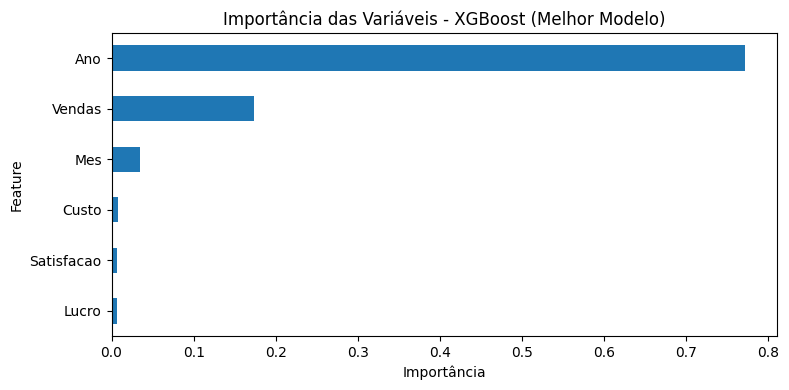

In [6]:
# === 10. Importância das variáveis ===
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)

plt.figure(figsize=(8, 4))
feat_imp.plot(kind="barh")
plt.title("Importância das Variáveis - XGBoost (Melhor Modelo)")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [7]:

# === 11. Salvar o modelo final ===
best_model.save_model("xgb_best_model.json")
joblib.dump(best_model, "xgb_best_model.pkl")

print("\n✅ Modelo salvo como 'xgb_best_model.json' e 'xgb_best_model.pkl'.")
print("Pronto para uso em previsões futuras!")



✅ Modelo salvo como 'xgb_best_model.json' e 'xgb_best_model.pkl'.
Pronto para uso em previsões futuras!


In [8]:
# === 12. Carregar modelo treinado ===
model = joblib.load("xgb_best_model.pkl") 

In [9]:
# === 13. Gerar previsões para os próximos 8 meses ===
predicoes_futuras = []

for pdv_id, grupo in df.groupby("PDV_ID"):
    ultimo_registro = grupo.sort_values("Data").iloc[-1].copy()
    base_pred = []

    mes = int(ultimo_registro["Mes"])
    ano = int(ultimo_registro["Ano"])

    for i in range(1, 9):  # próximos 8 meses
        mes += 1
        if mes > 12:
            mes = 1
            ano += 1

        nova_linha = ultimo_registro.copy()
        nova_linha["Mes"] = mes
        nova_linha["Ano"] = ano

        # aqui você pode manter os últimos valores de Vendas, Custo, etc.
        base_pred.append(nova_linha[features])

    # Cria DataFrame dos 8 próximos meses
    df_pred = pd.DataFrame(base_pred)

    # Prever metas
    df_pred["Meta_Prevista"] = model.predict(df_pred[features])

    # Adicionar PDV e datas projetadas
    df_pred["PDV_ID"] = pdv_id
    predicoes_futuras.append(df_pred)

# === 14. Concatenar todas as previsões ===
df_futuro = pd.concat(predicoes_futuras, ignore_index=True)


In [10]:
# === 15. Mostrar resultados ===
print(df_futuro[["PDV_ID", "Ano", "Mes", "Meta_Prevista"]])


    PDV_ID   Ano  Mes  Meta_Prevista
0    PDV_1  2025    1    2731.460938
1    PDV_1  2025    2    2682.460938
2    PDV_1  2025    3    2763.676514
3    PDV_1  2025    4    2764.173584
4    PDV_1  2025    5    2675.534912
..     ...   ...  ...            ...
419  PDV_9  2025    4    2747.740723
420  PDV_9  2025    5    2642.135742
421  PDV_9  2025    6    2601.399902
422  PDV_9  2025    7    2514.205566
423  PDV_9  2025    8    2350.937500

[424 rows x 4 columns]


In [11]:
# === 16. (Opcional) Salvar em Excel ===
df_futuro.to_excel("previsao_8_meses_por_pdv.xlsx", index=False)
print("\n✅ Previsões salvas em 'previsao_8_meses_por_pdv.xlsx'")


✅ Previsões salvas em 'previsao_8_meses_por_pdv.xlsx'
